# Chapter 8 Using Python to extend Pyspark via UDFs
we will disucss
- How to promote regular Python functions to UDFs to run in a distributed fashion
- How to apply UDFs on local data to ease debugging

In [187]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# change the account name to your email account
account='sli'

# define a root path to access the data in the DataAnalysisWithPythonAndPySpark
root_path='/net/clusterhn/home/'+account+'/isa460/Data/'

# append path to helper_functions to system path
sys.path.append('/net/clusterhn/home/sli/isa460_sli')

import helper_functions as H

# check if the Spark session is active. If it is activate, close it

try:
    if spark:
        spark.stop()
except:
    pass    

spark = (SparkSession.builder.appName("Weather Data Frame")
        .config("spark.port.maxRetries", "100")
        .config("spark.sql.mapKeyDedupPolicy", "LAST_WIN")  # This configuration allow the duplicate keys in the map data type.
        .config("spark.driver.memory", "16g")
        .getOrCreate())

# confiture the log level (defaulty is WARN)
spark.sparkContext.setLogLevel('ERROR')

# Weather data
For this exercise, we will use the [National Oceanic and Atmospheric Administration’s (NOAA) Global Surface Summary of the Day (GSOD) data set](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00516/html#) from Google BigQuery. We will focus on a particular weather station (Boston Logon 725090) between 2017-2019. See [data definition](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) for each field

In [188]:
# load data
gsod=spark.read.parquet(root_path+'window/gsod.parquet').filter(F.col('stn')=='725090')

In [11]:
gsod.count()

1095

In [189]:
H.displayByGroup(gsod.orderBy('year', 'mo', 'da'), 5)

+------+-----+----+---+---+----+
|stn   |wban |year|mo |da |temp|
+------+-----+----+---+---+----+
|725090|14739|2017|01 |01 |40.0|
|725090|14739|2017|01 |02 |35.1|
|725090|14739|2017|01 |03 |41.3|
|725090|14739|2017|01 |04 |42.6|
|725090|14739|2017|01 |05 |31.9|
+------+-----+----+---+---+----+
only showing top 5 rows



+----------+----+----------+------+---------+------+
|count_temp|dewp|count_dewp|slp   |count_slp|stp   |
+----------+----+----------+------+---------+------+
|24        |29.7|24        |1016.8|22       |1015.4|
|24        |25.5|24        |1032.5|24       |1031.5|
|24        |38.4|24        |1024.1|15       |1021.6|
|24        |39.9|24        |996.5 |14       |995.5 |
|24        |16.5|24        |1007.2|24       |1005.7|
+----------+----+----------+------+---------+------+
only showing top 5 rows



+---------+-----+-----------+----+----------+
|count_stp|visib|count_visib|wdsp|count_wdsp|
+---------+-----+-----------+----+----------+
|24       |9.9  |24         |13.3|24        |
|24       |10.0 |24         |3.7 |24        |
|24       |6.7  |24         |13.3|24        |
|24       |6.7  |24         |11.3|24        |
|24       |9.8  |24         |14.8|24        |
+---------+-----+-----------+----+----------+
only showing top 5 rows

+-----+-----+----+--------+----+
|mxpsd|gust |max |flag_max|min |
+-----+-----+----+--------+----+
|21.0 |28.9 |44.1|        |36.0|
|9.9  |999.9|44.1|        |28.0|
|22.9 |28.0 |43.0|        |28.0|
|18.1 |26.0 |48.0|        |37.0|
|20.0 |29.9 |48.0|        |27.0|
+-----+-----+----+--------+----+
only showing top 5 rows



+--------+----+---------+-----+---+
|flag_min|prcp|flag_prcp|sndp |fog|
+--------+----+---------+-----+---+
|        |0.14|G        |999.9|0  |
|        |0.07|G        |999.9|0  |
|        |0.03|G        |999.9|0  |
|        |0.88|G        |999.9|0  |
|        |0.04|G        |999.9|0  |
+--------+----+---------+-----+---+
only showing top 5 rows

+------------+----------------+----+-------+--------------------+
|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------------+----------------+----+-------+--------------------+
|1           |0               |0   |0      |0                   |
|0           |0               |0   |0      |0                   |
|1           |0               |0   |0      |0                   |
|1           |0               |0   |0      |0                   |
|1           |1               |0   |0      |0                   |
+------------+----------------+----+-------+--------------------+
only showing top 5 rows



## find average temp by month

In [18]:
result=gsod.groupBy('year','mo').agg(F.round(F.avg('temp'),2).alias('avgTemp')).orderBy('year', 'mo')

result.show()


+----+---+-------+
|year| mo|avgTemp|
+----+---+-------+
|2017| 01|  35.38|
|2017| 02|  36.12|
|2017| 03|  34.11|
|2017| 04|  51.12|
|2017| 05|  55.92|
|2017| 06|   69.1|
|2017| 07|  72.02|
|2017| 08|  71.46|
|2017| 09|  66.64|
|2017| 10|  61.29|
|2017| 11|  44.08|
|2017| 12|  30.69|
|2018| 01|  28.69|
|2018| 02|  38.06|
|2018| 03|  36.69|
|2018| 04|  44.72|
|2018| 05|  60.95|
|2018| 06|  67.42|
|2018| 07|  75.89|
|2018| 08|  76.91|
+----+---+-------+
only showing top 20 rows



In [20]:
# visualize the result
df=result.toPandas()
df.head()

,year,mo,avgTemp
0,2017,01,35.38
1,2017,02,36.12
2,2017,03,34.11
3,2017,04,51.12
4,2017,05,55.92


Text(0, 0.5, 'Average Tempperature')

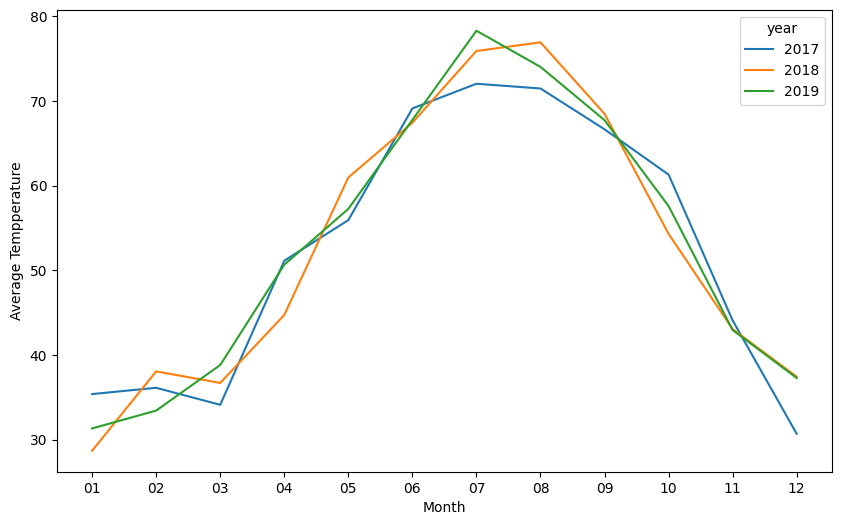

In [26]:
plt.figure(figsize=(10,6))

sns.lineplot(data=df, x='mo', y='avgTemp', hue='year')

plt.xlabel('Month')
plt.ylabel('Average Temperature')

## Find average daily temperature change by month

In [32]:
gsod.select('year', 'mo', 'da', 'temp').orderBy('year', 'mo', 'da').show()

+----+---+---+----+
|year| mo| da|temp|
+----+---+---+----+
|2017| 01| 01|40.0|
|2017| 01| 02|35.1|
|2017| 01| 03|41.3|
|2017| 01| 04|42.6|
|2017| 01| 05|31.9|
|2017| 01| 06|28.7|
|2017| 01| 07|22.7|
|2017| 01| 08|17.9|
|2017| 01| 09|15.4|
|2017| 01| 10|22.9|
|2017| 01| 11|45.4|
|2017| 01| 12|50.1|
|2017| 01| 13|48.6|
|2017| 01| 14|25.8|
|2017| 01| 15|31.4|
|2017| 01| 16|31.3|
|2017| 01| 17|37.2|
|2017| 01| 18|37.8|
|2017| 01| 19|36.6|
|2017| 01| 20|38.2|
+----+---+---+----+
only showing top 20 rows



In [41]:
gsod1=gsod.select('year', 'mo', 'da', 'temp').orderBy('year', 'mo', 'da').withColumn('day_temp', F.create_map('da', 'temp'))

gsod1.show()

+----+---+---+----+------------+
|year| mo| da|temp|    day_temp|
+----+---+---+----+------------+
|2017| 01| 01|40.0|{01 -> 40.0}|
|2017| 01| 02|35.1|{02 -> 35.1}|
|2017| 01| 03|41.3|{03 -> 41.3}|
|2017| 01| 04|42.6|{04 -> 42.6}|
|2017| 01| 05|31.9|{05 -> 31.9}|
|2017| 01| 06|28.7|{06 -> 28.7}|
|2017| 01| 07|22.7|{07 -> 22.7}|
|2017| 01| 08|17.9|{08 -> 17.9}|
|2017| 01| 09|15.4|{09 -> 15.4}|
|2017| 01| 10|22.9|{10 -> 22.9}|
|2017| 01| 11|45.4|{11 -> 45.4}|
|2017| 01| 12|50.1|{12 -> 50.1}|
|2017| 01| 13|48.6|{13 -> 48.6}|
|2017| 01| 14|25.8|{14 -> 25.8}|
|2017| 01| 15|31.4|{15 -> 31.4}|
|2017| 01| 16|31.3|{16 -> 31.3}|
|2017| 01| 17|37.2|{17 -> 37.2}|
|2017| 01| 18|37.8|{18 -> 37.8}|
|2017| 01| 19|36.6|{19 -> 36.6}|
|2017| 01| 20|38.2|{20 -> 38.2}|
+----+---+---+----+------------+
only showing top 20 rows



In [48]:
gsod1.groupBy('year', 'mo').agg(F.collect_list(F.map_values('day_temp')).alias('temp_list')).orderBy('year', 'mo').show(10, False)

+----+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                                                                               |
+----+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2017|01 |[[40.0], [35.1], [41.3], [42.6], [31.9], [28.7], [22.7], [17.9], [15.4], [22.9], [45.4], [50.1], [48.6], [25.8], [31.4], [31.3], [37.2], [37.8], [36.6], [38.2], [42.8], [43.9], [37.9], [38.8], [38.5], [42.3], [

In [57]:
gsod2=gsod1.groupBy('year', 'mo').agg(F.collect_list(F.map_values('day_temp')).alias('temp_list')).orderBy('year', 'mo')

gsod3=gsod2.withColumn('temp_list', F.flatten('temp_list'))

gsod3.show(5, False)

+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                 |
+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2017|01 |[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]|
|2017|02 |[32.2, 35.8, 29.6, 26.8, 32.2, 35.9, 34.6, 36.6, 32.4, 16.5, 20.8, 25.4, 30.4, 27.2, 32.4, 33.4, 30.3, 36.4, 48.8, 44.3, 35.4, 42.6, 49.3, 56.9, 57.1, 44.4, 39.6, 44.0]                  |
|2017|03 |

In [63]:
# we will create a python function to calcuate the average of daily temperature change
# write the code to calcuate the average
temp_list=[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]

temp_change_list=[]
total_days=len(temp_list)

for i in range(0, total_days-1):
    current_temp=temp_list[i]
    next_temp=temp_list[i+1]
    temp_diff=abs(next_temp-current_temp)
    temp_change_list.append(temp_diff)
    
avgTemp=sum(temp_change_list)/len(temp_change_list)
avgTemp

4.923333333333332

In [65]:
def avgTempChange(temp_list):
    temp_change_list=[]
    total_days=len(temp_list)

    for i in range(0, total_days-1):
        current_temp=temp_list[i]
        next_temp=temp_list[i+1]
        temp_diff=abs(next_temp-current_temp)
        temp_change_list.append(temp_diff)
    
    avgTemp=sum(temp_change_list)/len(temp_change_list)
    return avgTemp

4.923333333333332

## Use udf() function to promot Python function to Pyspark UDF. This function take two parameters:
- The function you want to promote

- The return type of the generated UDF


In [68]:
avgTempChange_udf=F.udf(avgTempChange, T.DoubleType())

In [70]:
gsod3.show(5, False)

+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                 |
+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2017|01 |[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]|
|2017|02 |[32.2, 35.8, 29.6, 26.8, 32.2, 35.9, 34.6, 36.6, 32.4, 16.5, 20.8, 25.4, 30.4, 27.2, 32.4, 33.4, 30.3, 36.4, 48.8, 44.3, 35.4, 42.6, 49.3, 56.9, 57.1, 44.4, 39.6, 44.0]                  |
|2017|03 |

In [91]:
# apply the function to pyspark column

gsod4=gsod3.withColumn('avgTempChange', F.round(avgTempChange_udf(F.col('temp_list')),2))

gsod4.show()

+----+---+--------------------+-------------+
|year| mo|           temp_list|avgTempChange|
+----+---+--------------------+-------------+
|2017| 01|[40.0, 35.1, 41.3...|         4.92|
|2017| 02|[32.2, 35.8, 29.6...|         5.44|
|2017| 03|[52.8, 50.0, 31.3...|         6.41|
|2017| 04|[35.2, 40.6, 46.8...|         5.99|
|2017| 05|[46.9, 49.5, 56.5...|         4.65|
|2017| 06|[66.5, 65.1, 61.3...|         3.89|
|2017| 07|[76.1, 78.9, 80.1...|         4.05|
|2017| 08|[74.4, 73.7, 73.6...|         2.39|
|2017| 09|[62.3, 60.5, 59.8...|         3.59|
|2017| 10|[54.7, 58.6, 58.5...|         4.54|
|2017| 11|[48.3, 58.6, 64.3...|         6.93|
|2017| 12|[46.3, 39.1, 39.3...|         4.91|
|2018| 01|[5.6, 9.9, 20.8, ...|         7.84|
|2018| 02|[34.7, 32.4, 17.1...|         7.03|
|2018| 03|[47.5, 40.1, 39.5...|         2.79|
|2018| 04|[47.9, 37.1, 37.9...|         4.64|
|2018| 05|[51.5, 71.5, 74.0...|         6.71|
|2018| 06|[70.4, 73.1, 58.2...|         4.63|
|2018| 07|[82.4, 73.0, 84.4...|   

Text(0, 0.5, 'Average Daily Temperature Change')

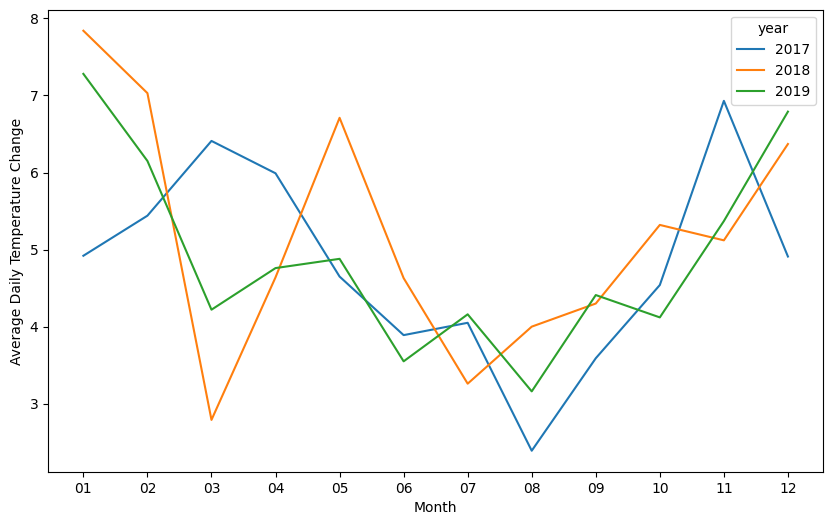

In [92]:
# visualize the result

df=gsod4.toPandas()

plt.figure(figsize=(10,6))

sns.lineplot(data=df, x='mo', y='avgTempChange', hue='year')

plt.xlabel('Month')
plt.ylabel('Average Daily Temperature Change')

In [95]:
df.head()

,year,mo,temp_list,avgTempChange
0,2017,01,"[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17....",4.92
1,2017,02,"[32.2, 35.8, 29.6, 26.8, 32.2, 35.9, 34.6, 36....",5.44
2,2017,03,"[52.8, 50.0, 31.3, 19.5, 17.9, 25.1, 36.5, 50....",6.41
3,2017,04,"[35.2, 40.6, 46.8, 41.6, 39.5, 38.9, 48.4, 43....",5.99
4,2017,05,"[46.9, 49.5, 56.5, 51.2, 49.0, 56.2, 57.6, 50....",4.65


In [96]:
df['year_month']=df['year'].str[2:]+'-'+df['mo']
df.head()

,year,mo,temp_list,avgTempChange,year_month
0,2017,01,"[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17....",4.92,17-01
1,2017,02,"[32.2, 35.8, 29.6, 26.8, 32.2, 35.9, 34.6, 36....",5.44,17-02
2,2017,03,"[52.8, 50.0, 31.3, 19.5, 17.9, 25.1, 36.5, 50....",6.41,17-03
3,2017,04,"[35.2, 40.6, 46.8, 41.6, 39.5, 38.9, 48.4, 43....",5.99,17-04
4,2017,05,"[46.9, 49.5, 56.5, 51.2, 49.0, 56.2, 57.6, 50....",4.65,17-05


<Axes: xlabel='year_month', ylabel='avgTempChange'>

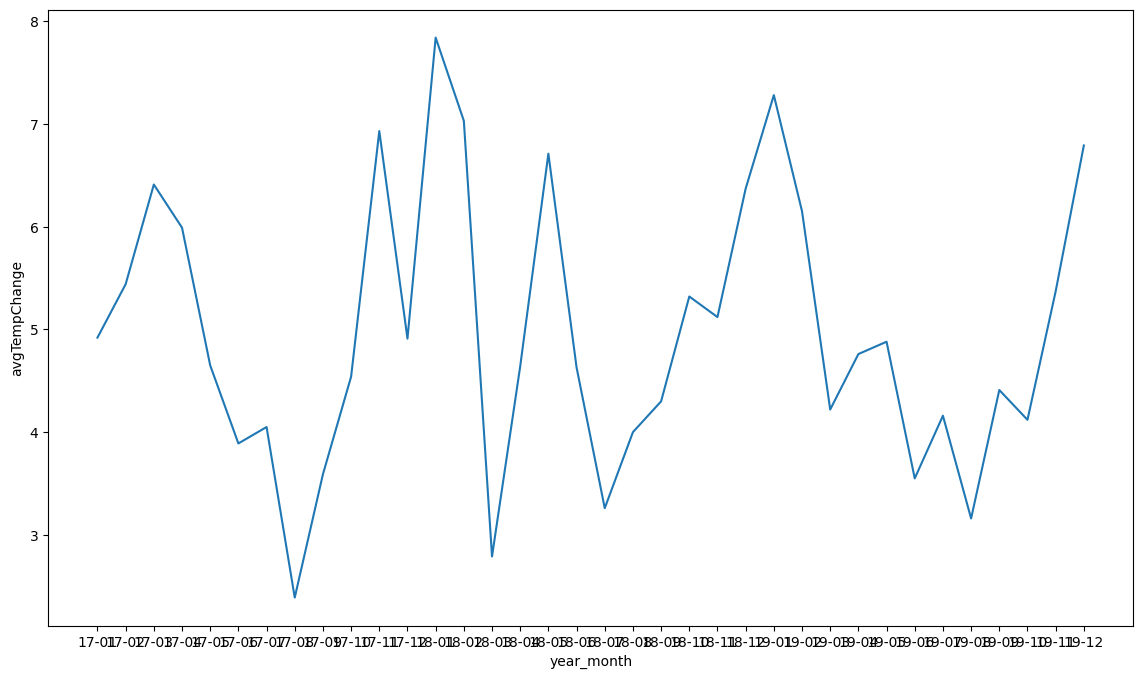

In [97]:
plt.figure(figsize=(14,8))
           
sns.lineplot(data=df, x='year_month', y='avgTempChange')

# we can see x-axis labels become cluttered.

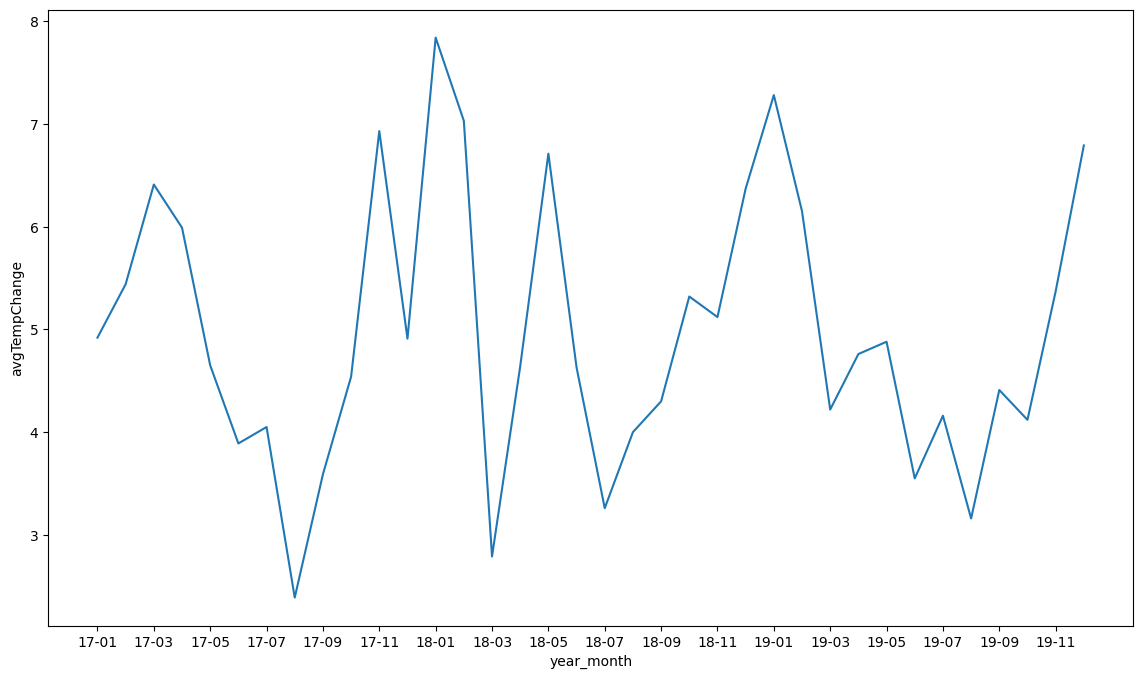

In [98]:
plt.figure(figsize=(14,8))
           
plot=sns.lineplot(data=df, x='year_month', y='avgTempChange')

# Adjust x-axis labels
x_ticks = plot.get_xticks()
plot.set_xticks(x_ticks[::2])  # Show every 2nd label

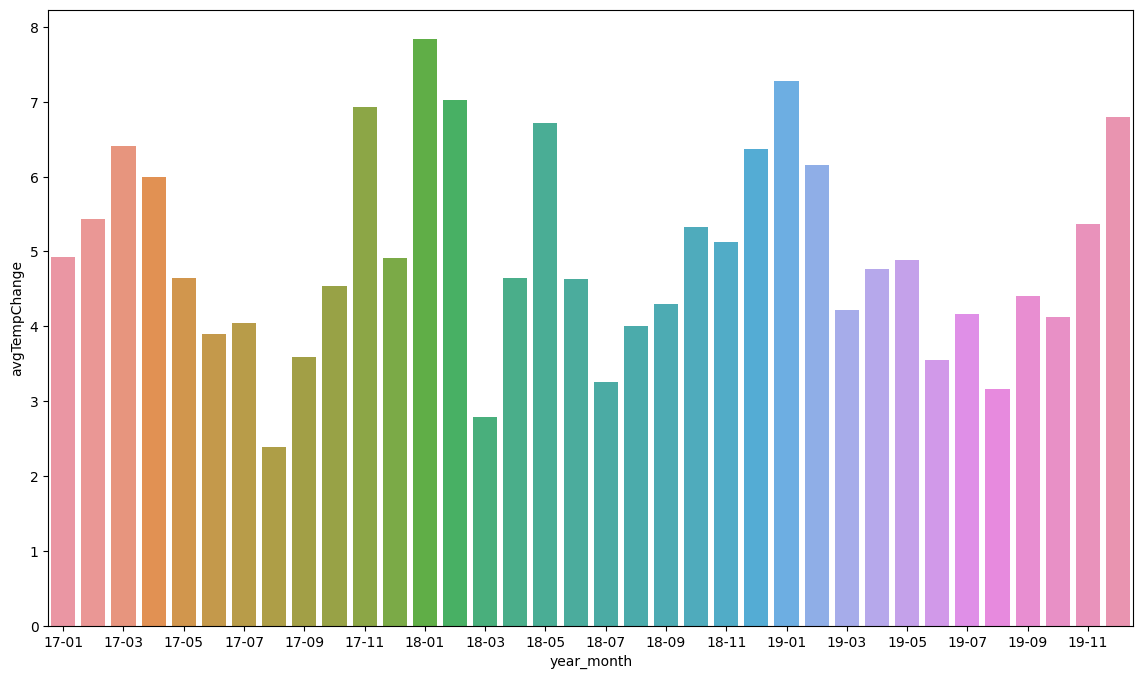

In [99]:
plt.figure(figsize=(14,8))
           
plot=sns.barplot(data=df, x='year_month', y='avgTempChange')

# Adjust x-axis labels
x_ticks = plot.get_xticks()
plot.set_xticks(x_ticks[::2])  # Show every 2nd label

## modify the below function to return max temp change and min temp change by month, besides average temp change

In [104]:
def avgTempChange(temp_list):
    temp_change_list=[]
    total_days=len(temp_list)

    for i in range(0, total_days-1):
        current_temp=temp_list[i]
        next_temp=temp_list[i+1]
        temp_diff=abs(next_temp-current_temp)
        temp_change_list.append(temp_diff)
    
    avgTemp=round(sum(temp_change_list)/len(temp_change_list),2)
    maxTemp=round(max(temp_change_list),2)
    minTemp=round(min(temp_change_list),2)
    return {'avgTempChange': avgTemp, 'maxTempChange': maxTemp, 'minTempChange':minTemp}
 

In [105]:
avgTempChange(temp_list)

{'avgTempChange': 4.92, 'maxTempChange': 22.8, 'minTempChange': 0.1}

In [110]:
# registe the above python UDF as psypark UDF

avgTempChange_udf=F.udf(avgTempChange, T.MapType(T.StringType(), T.DoubleType()))

In [111]:
gsod3.show(5, False)

+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                 |
+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2017|01 |[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]|
|2017|02 |[32.2, 35.8, 29.6, 26.8, 32.2, 35.9, 34.6, 36.6, 32.4, 16.5, 20.8, 25.4, 30.4, 27.2, 32.4, 33.4, 30.3, 36.4, 48.8, 44.3, 35.4, 42.6, 49.3, 56.9, 57.1, 44.4, 39.6, 44.0]                  |
|2017|03 |

In [114]:
gsod4=gsod3.withColumn('temp_change', avgTempChange_udf('temp_list'))

gsod4.show(5, False)

+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                 |temp_change                                                         |
+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|2017|01 |[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]|{m

In [120]:
# extract max temp, min temp and avg temp change

gsod5=gsod4.withColumn('avgTempChange', F.col('temp_change').getItem('avgTempChange')).withColumn('maxTempChange', F.col('temp_change').
            getItem('maxTempChange')).withColumn('minTempChange', F.col('temp_change').getItem('minTempChange'))
gsod5.select('year', 'mo', 'avgTempChange', 'maxTempChange', 'minTempChange').show()

+----+---+-------------+-------------+-------------+
|year| mo|avgTempChange|maxTempChange|minTempChange|
+----+---+-------------+-------------+-------------+
|2017| 01|         4.92|         22.8|          0.1|
|2017| 02|         5.44|         15.9|          0.2|
|2017| 03|         6.41|         18.7|          0.1|
|2017| 04|         5.99|         20.2|          0.4|
|2017| 05|         4.65|         22.0|          0.5|
|2017| 06|         3.89|         13.7|          0.2|
|2017| 07|         4.05|         10.4|          0.1|
|2017| 08|         2.39|          8.0|          0.1|
|2017| 09|         3.59|         15.4|          0.1|
|2017| 10|         4.54|         14.6|          0.0|
|2017| 11|         6.93|         18.8|          0.1|
|2017| 12|         4.91|         12.9|          0.2|
|2018| 01|         7.84|         31.2|          0.1|
|2018| 02|         7.03|         17.3|          0.0|
|2018| 03|         2.79|          8.7|          0.1|
|2018| 04|         4.64|         11.7|        

In [121]:
df=gsod5.select('year', 'mo', 'avgTempChange', 'maxTempChange', 'minTempChange').toPandas()

df.head()

,year,mo,avgTempChange,maxTempChange,minTempChange
0,2017,01,4.92,22.8,0.1
1,2017,02,5.44,15.9,0.2
2,2017,03,6.41,18.7,0.1
3,2017,04,5.99,20.2,0.4
4,2017,05,4.65,22.0,0.5


In [124]:
df1=df.melt(id_vars=['year', 'mo'], var_name='tempStats', value_name='tempChange')

df1.head()

,year,mo,tempStats,tempChange
0,2017,01,avgTempChange,4.92
1,2017,02,avgTempChange,5.44
2,2017,03,avgTempChange,6.41
3,2017,04,avgTempChange,5.99
4,2017,05,avgTempChange,4.65


In [126]:
df1['year_month']=df1['year'].str[2:]+'-'+df1['mo']
df1.head()

,year,mo,tempStats,tempChange,year_month
0,2017,01,avgTempChange,4.92,17-01
1,2017,02,avgTempChange,5.44,17-02
2,2017,03,avgTempChange,6.41,17-03
3,2017,04,avgTempChange,5.99,17-04
4,2017,05,avgTempChange,4.65,17-05


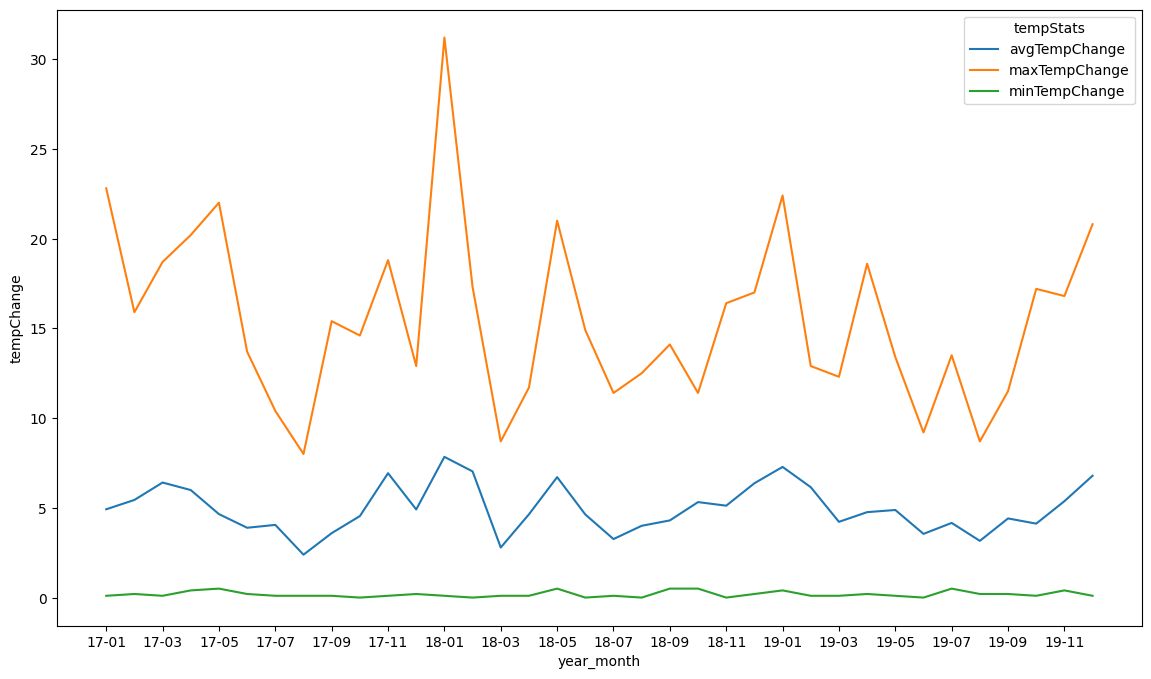

In [131]:
plt.figure(figsize=(14,8))

plot=sns.lineplot(data=df1, x='year_month', y='tempChange', hue='tempStats')

# Adjust x-axis labels
x_ticks = plot.get_xticks()
plot.set_xticks(x_ticks[::2])  # Show every 2nd label

## use the UDF function as a decorator
You also have the option of creating your Python function and promoting it as a UDF using the udf function as a decorator. Decorators are functions applied to other functions through the @ sign above the function definition (we call that function decorated). This allows for changing the behavior of a function—here, we create a UDF from a regular Python function definition—with minimal boilerplate

In [133]:
@F.udf(T.MapType(T.StringType(), T.DoubleType()))
def avgTempChange(temp_list):
    temp_change_list=[]
    total_days=len(temp_list)

    for i in range(0, total_days-1):
        current_temp=temp_list[i]
        next_temp=temp_list[i+1]
        temp_diff=abs(next_temp-current_temp)
        temp_change_list.append(temp_diff)
    
    avgTemp=round(sum(temp_change_list)/len(temp_change_list),2)
    maxTemp=round(max(temp_change_list),2)
    minTemp=round(min(temp_change_list),2)
    return {'avgTempChange': avgTemp, 'maxTempChange': maxTemp, 'minTempChange':minTemp}

In [135]:
gsod3.show(5)

+----+---+--------------------+
|year| mo|           temp_list|
+----+---+--------------------+
|2017| 01|[40.0, 35.1, 41.3...|
|2017| 02|[32.2, 35.8, 29.6...|
|2017| 03|[52.8, 50.0, 31.3...|
|2017| 04|[35.2, 40.6, 46.8...|
|2017| 05|[46.9, 49.5, 56.5...|
+----+---+--------------------+
only showing top 5 rows



In [137]:
gsod3.withColumn('tempChange', avgTempChange('temp_list')).show(5, False)

+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|year|mo |temp_list                                                                                                                                                                                 |tempChange                                                          |
+----+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|2017|01 |[40.0, 35.1, 41.3, 42.6, 31.9, 28.7, 22.7, 17.9, 15.4, 22.9, 45.4, 50.1, 48.6, 25.8, 31.4, 31.3, 37.2, 37.8, 36.6, 38.2, 42.8, 43.9, 37.9, 38.8, 38.5, 42.3, 40.7, 37.2, 36.0, 32.9, 24.9]|{m

## In class/Take Home exercise

### Q1. Display the average, max, min precipitation (use column prcp) by month. Visualize the result

In [138]:
# load data
gsod=spark.read.parquet(root_path+'window/gsod.parquet').filter(F.col('stn')=='725090')

### Q2 Display the daily average, max, min precipitation (use column prcp) change by month. Visualize the result